# Open files from Google Drive


In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import our Libraries

In [15]:
try:

    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import cv2
    import os
    from os import listdir
    import seaborn as sns
    import matplotlib.pyplot as plt
    from imutils import paths
    import argparse
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications import Xception
    from tensorflow.keras.layers import AveragePooling2D
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print("Library Loaded Successfully ..........")
except:
    print("Library not Found ! ")

Library Loaded Successfully ..........


#Authenticate Google Drive Access


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Linking Colab Notebook to the Module


In [0]:
your_module = drive.CreateFile({'id':'1N49mfoPCpjKd_b_t9j1iFNR8UFA0xwyf'})
your_module.GetContentFile('ReadAndPreprocessing.py')

# Import my own module and use it to read the dataset and preprocessing it

In [18]:
import time 

start = time.time()

from ReadAndPreprocessing import MasterImage

if __name__ == "__main__":
    path = '/content/gdrive/My Drive/grad_project/Dataset'
    a = MasterImage(PATH=path,
                    IMAGE_SIZE=250)

    X,y  = a.Process_Image()
    print(X.shape)
    print(y.shape)


end = time.time()
duration_time = end - start
print("Duration time executed = ", duration_time)

Found Categories  ['(NH4)Cr2O7', '2H2O', '2Mg', '2NaOH', 'Zn', '2HgO', 'CuSO4', 'Mg'] 

(2560, 250, 250, 3)
(2560,)
Duration time executed =  48.82852816581726


In [19]:
tf.__version__

'2.2.0'

In [20]:
# first 10 targets
y[:]

array([0, 0, 0, ..., 7, 7, 7])

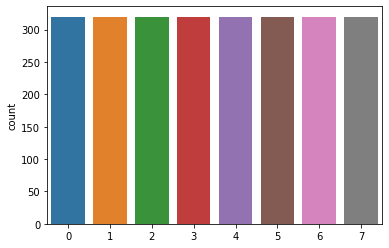

In [21]:
g = sns.countplot(y)

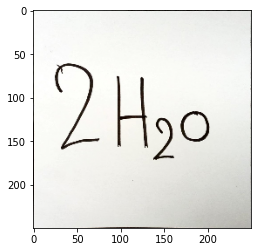

In [22]:
g = plt.imshow(X[500])

# Splitting data to training and validation data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print('List of some targets = ', y_train[:10])
print('X train shape = ',X_train.shape)
print('X test shape = ',X_test.shape)
print('y train shape = ',y_train.shape)
print('y test shape = ',y_test.shape)

List of some targets =  [5 7 7 1 5 3 6 4 2 4]
X train shape =  (2048, 250, 250, 3)
X test shape =  (512, 250, 250, 3)
y train shape =  (2048,)
y test shape =  (512,)


# Data Augmentaion

In [0]:
train_Aug = ImageDataGenerator(rotation_range=10,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1)

## Create the base model from the pre-trained model

Create the base model from the **Xception** model , and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of Xception will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Xception model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [25]:
IMAGE_SHAPE = (250, 250, 3)

# Create the base model from the pre-trained model Xception
base_model = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(250, 250, 3)))

83689472/83683744 [==============================] - 1s 0us/step


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

### Add a classification head



In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.AveragePooling2D(pool_size=(4, 4)),
  tf.keras.layers.Flatten(name="flatten"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(8, activation="softmax")
])

### Compile the model

You must compile the model before training it.  Since there are multiple classes, use a sparse categorical crossentropy loss.

In [0]:
INIT_LR = 1e-3
BS = 8
EPOCHS = 50
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", 
                                       optimizer=opt,
                                  metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 21,386,352
Trainable params: 524,872
Non-trainable params: 20,861,480
______________________________________

# Train the model
Paused it because it it has already been trained before we just need to load it



In [30]:
EPOCHS = 100

history = model.fit_generator(train_Aug.flow(X_train, y_train, batch_size=BS),
	                            steps_per_epoch=len(X_train) // BS,
	                            validation_data=(X_test, y_test),
	                            validation_steps=len(X_test) // BS,
	                            epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
256/256 [==============================] - 55s 215ms/step - loss: 1.6032 - accuracy: 0.3774 - val_loss: 0.9312 - val_accuracy: 0.7109
Epoch 2/100
256/256 [==============================] - 55s 213ms/step - loss: 1.1570 - accuracy: 0.5576 - val_loss: 0.6894 - val_accuracy: 0.8145
Epoch 3/100
256/256 [==============================] - 55s 216ms/step - loss: 0.9569 - accuracy: 0.6348 - val_loss: 0.5391 - val_accuracy: 0.8828
Epoch 4/100
256/256 [==============================] - 55s 213ms/step - loss: 0.8236 - accuracy: 0.6753 - val_loss: 0.4966 - val_accuracy: 0.8477
Epoch 5/100
256/256 [==============================] - 55s 216ms/step - loss: 0.7488 - accuracy: 0.7139 - val_loss: 0.4523 - val_accuracy: 0.8496
Epoch 6/100
256/256 [==============================] - 55s 215ms/step - loss: 0.7330 - accuracy: 0.7256 - val_loss: 0.4329 - val_accuracy: 0.8730
Epoch 7/100
256/256 [===========================

# Evaluate the new version model with 100 Epochs

In [37]:
loss ,acc = model.evaluate(X_test,y_test) 

16/16 [==============================] - 8s 470ms/step - loss: 0.1955 - accuracy: 0.9395


In [36]:
loss ,acc = model.evaluate(X_train,y_train)

64/64 [==============================] - 31s 491ms/step - loss: 0.0415 - accuracy: 0.9829


# Export the model 

In [42]:
filepath = '/content/drive/My Drive/Chem_Model/my_model_xception.h5'
new_model = tf.keras.models.load_model(filepath)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Evaluate previous model

In [43]:
loss ,acc = new_model.evaluate(X_test,y_test)

16/16 [==============================] - 8s 487ms/step - loss: 0.1594 - accuracy: 0.9473


In [44]:
loss ,acc = new_model.evaluate(X_train,y_train)

64/64 [==============================] - 30s 476ms/step - loss: 0.0651 - accuracy: 0.9771


# Testing predictions and the actual label 

In [45]:
# Testing predictions and the actual label
checkImage = X_test[1:2]
checklabel = y_test[1:2]

predict = model.predict(np.array(checkImage))
output = { 0:'(NH4)Cr2O',1:'2H2O',2:'2Mg',3:'2NaOH',4:'Zn',5:'2HgO',6:'CuSO4',7:'Mg'}

print("Actual : ",checklabel)
print("Predicted : ",output[np.argmax(predict)])

Actual :  [5]
Predicted :  2HgO


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the Xception base model as a fixed feature extractor. 

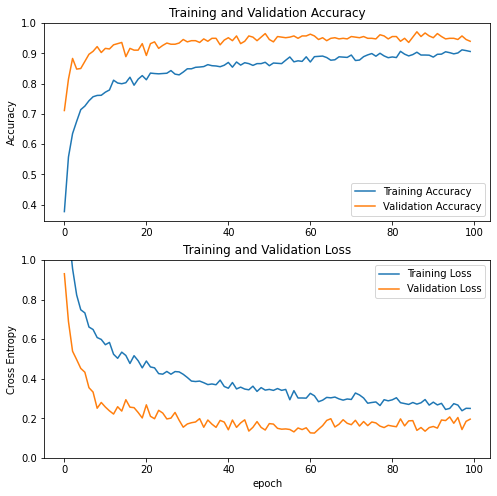

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#confusion matrix to measurement

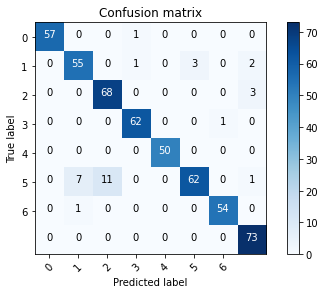

In [47]:
# Look at confusion matrix 
import itertools  

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = y_test
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

# Display some error results


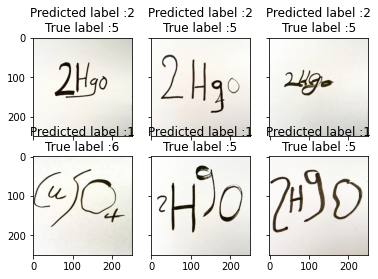

In [48]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((250,250,-1)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [49]:
saved_model_dir = 'save/xception_model'
tf.saved_model.save(new_model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/xception_model/assets


# Test the model with TFLite interpreter 

Download the converted model and labels

In [0]:
from google.colab import files
class_names = ['(NH4)Cr2O7', '2H2O', '2Mg', '2NaOH', 'Zn', '2HgO', 'CuSO4', 'Mg']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

files.download('model.tflite')
files.download('labels.txt')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 37928, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil